In [1]:
%matplotlib inline

In [2]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm_notebook, tqdm

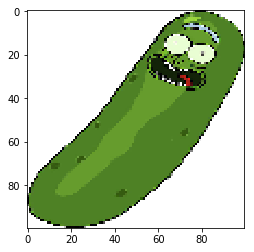

In [35]:
image = Image.open('pickle.png')
image = image.resize((100, 100))
x = np.asarray(image)
plt.imshow(x)

In [76]:
def find_closest(image, optimize, mutate, pop_size=100, n_iters=200):
    assert isinstance(image, np.ndarray)
    candidates = [(np.random.rand(*image.shape)*255).astype(np.uint8) for _ in range(pop_size)]
    mean_losses = []
    change_per_iter = pop_size // 5
    for i in tqdm_notebook(range(n_iters)):
        losses = [abs_error(image, candidate.astype(np.float32)) for candidate in candidates]
        mean_loss = min(losses)
#         tqdm.write(f'Nr of candidates: {len(candidates)}')
#         tqdm.write(f'Loss mean and std: {np.mean(losses)}, {np.std(losses)}')
#         tqdm.write(f'{mean_loss}')
        mean_losses.append(mean_loss)
        loss_df = pd.DataFrame(losses).sort_values(0)
        ordered_indexes = loss_df.index.tolist()
        
        candidates = [candidates[j] for j in ordered_indexes]
        if len(candidates) > pop_size:
            candidates = candidates[:pop_size]
        candidates = optimize(candidates, ordered_indexes, change_per_iter)
        candidates = mutate(candidates)

        if i % 10 == 0:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(candidates[ordered_indexes[0]])
            ax[1].imshow(image)
            plt.show()
    plt.plot(mean_losses)
    
def mse(image, candidate):
    return np.mean(np.square(image-candidate))

def abs_error(image, candidate):
    return np.sum(np.abs(image-candidate))

In [77]:
def optimize_simple(candidates, ordered_indexes, change_per_iter=5):
    # len(new_candidates) = change_per_iter * 5
    new_candidates = []
    for z in range(change_per_iter):
        image_a, image_b = candidates[z], candidates[z+2] # [candidates[t] for t in ordered_indexes[z: z+2]]
        child_a = np.mean([image_a, image_b], axis=0).astype(np.uint8)
#         child_b = np.abs(image_a - image_b).astype(np.uint8)
#         child_c = np.clip(image_a + image_b, 0, 255).astype(np.uint8)
#         assert child_a.shape == child_b.shape == child_c.shape == image_a.shape, f'{child_a.shape}, {child_b.shape}, {child_c.shape}'
        new_candidates += [child_a, image_a, image_b]
    assert isinstance(new_candidates, list)
    return candidates + new_candidates
    
def mutate_simple(candidates, rand_size=20):
    new_candidates = []
    for i, candidate in enumerate(candidates):
        # add noise from -0.5*rand_size to 0.5*rand_size
        noise = (np.random.rand(*candidates[0].shape)*rand_size-(rand_size//2)).astype(np.int8)
        mutated_candidate = np.clip(candidate + noise, 0, 255).astype(np.uint8)
        new_candidates.append(mutated_candidate) 
    assert isinstance(new_candidates, list)
    return candidates + new_candidates

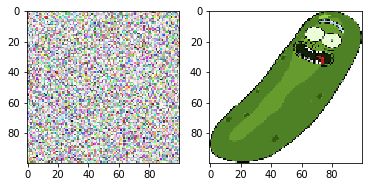

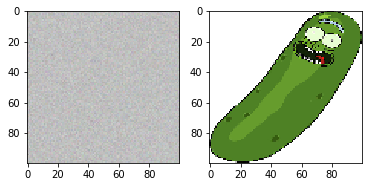

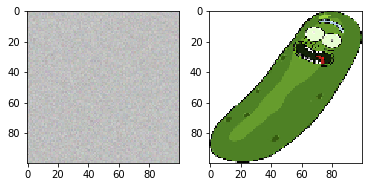

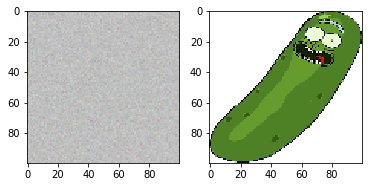

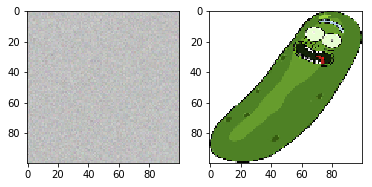

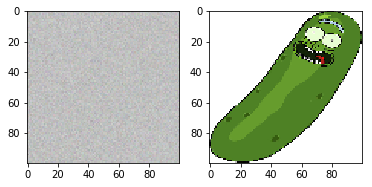

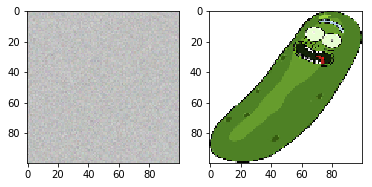

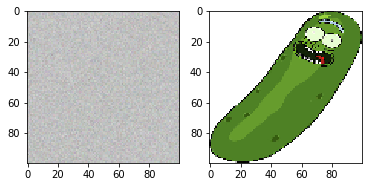

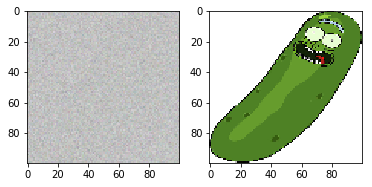

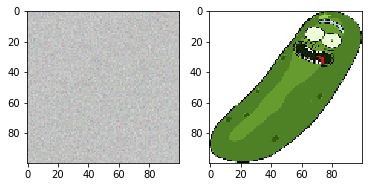

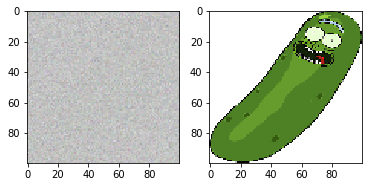

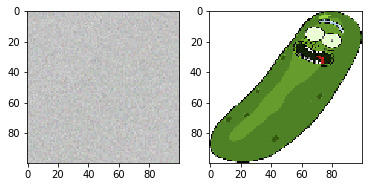

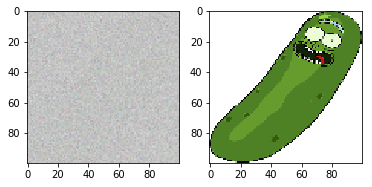

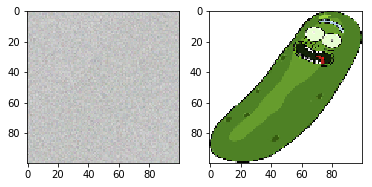

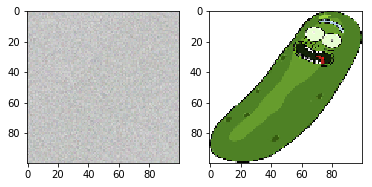

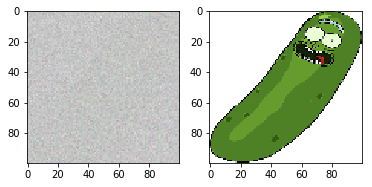

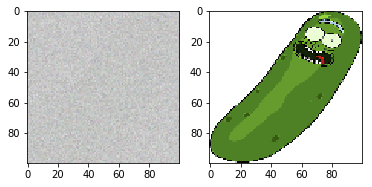

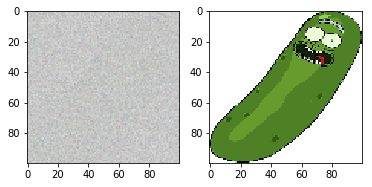

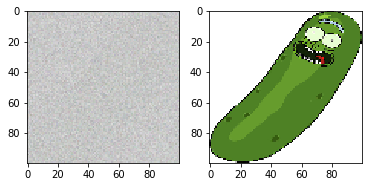

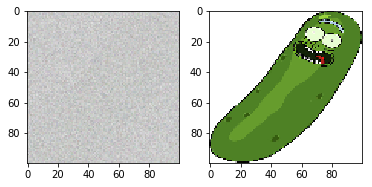

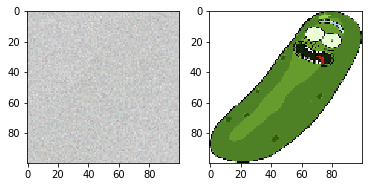

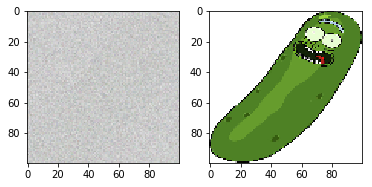

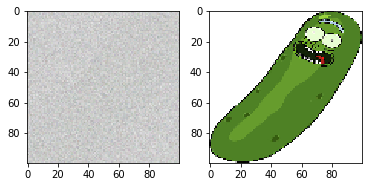

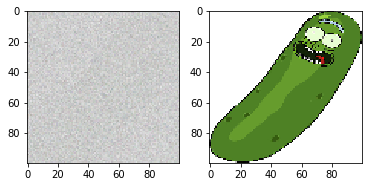

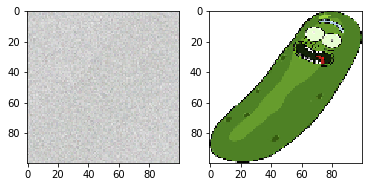

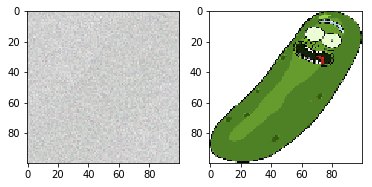

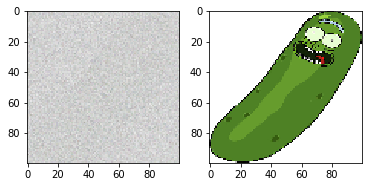

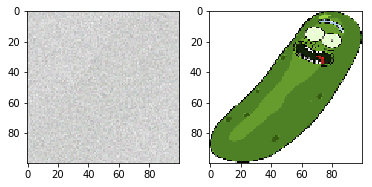

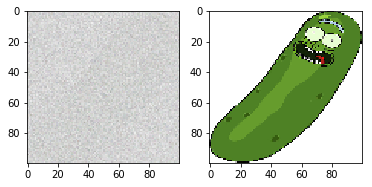

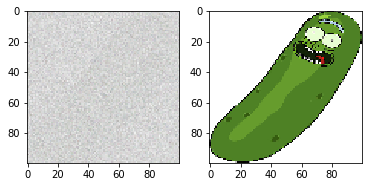

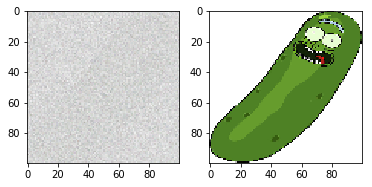

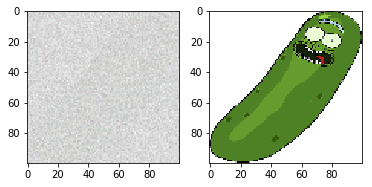

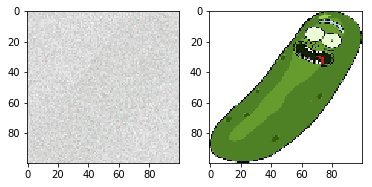

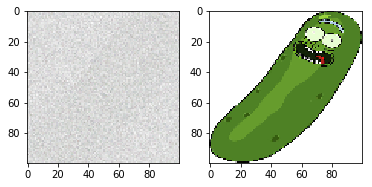

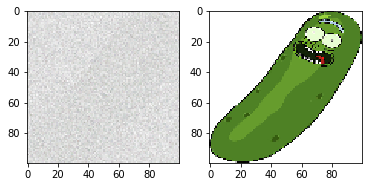

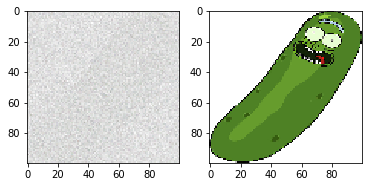

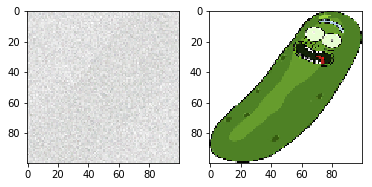

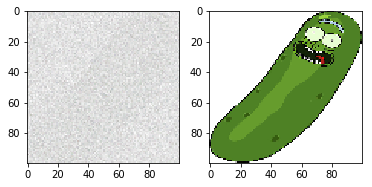

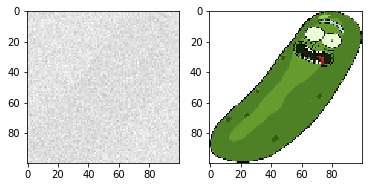

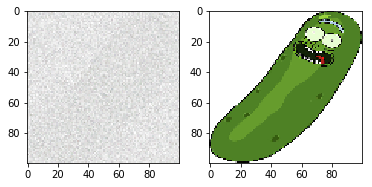

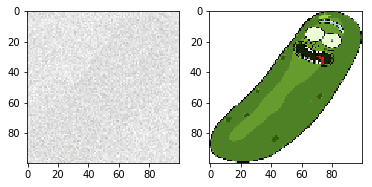

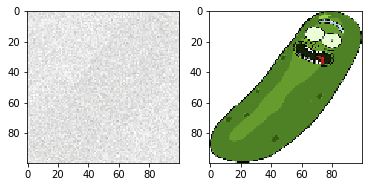

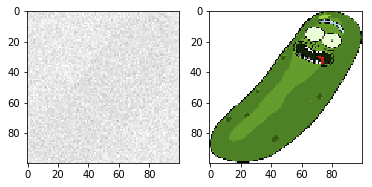

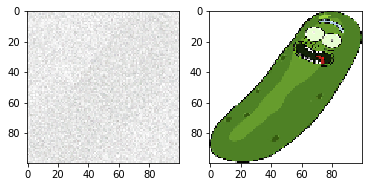

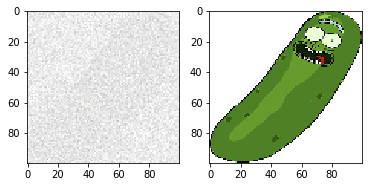

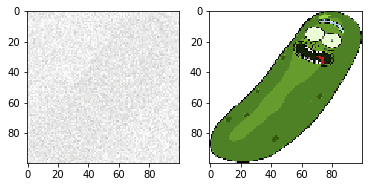

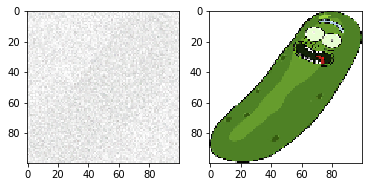

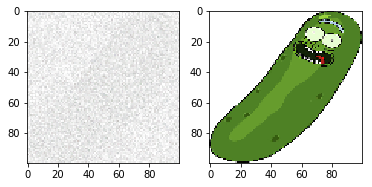

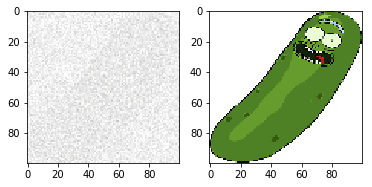

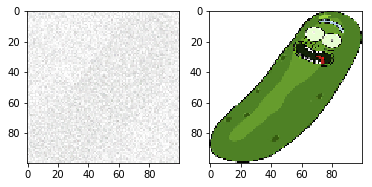

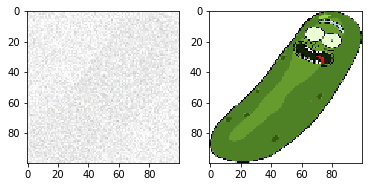

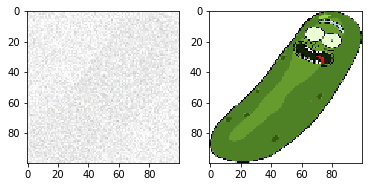

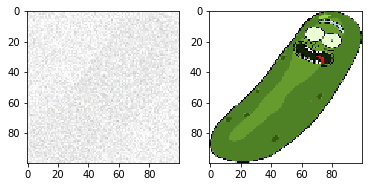

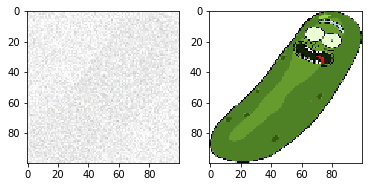

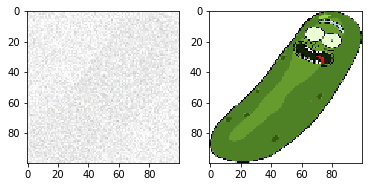

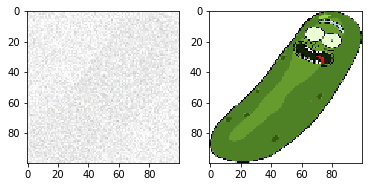

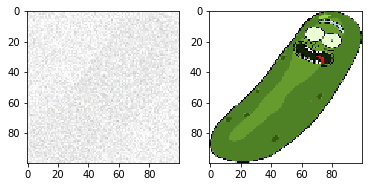

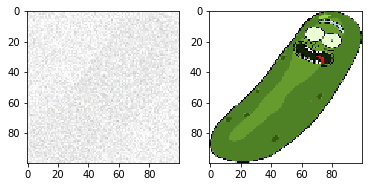

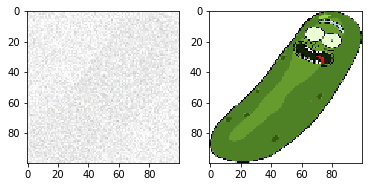

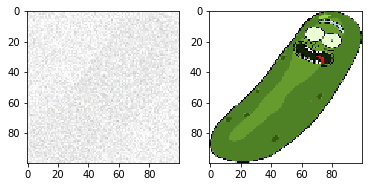

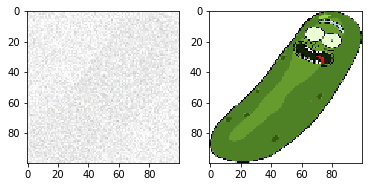

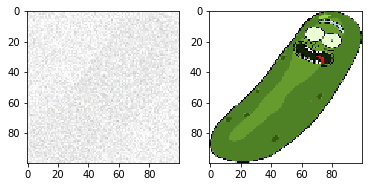

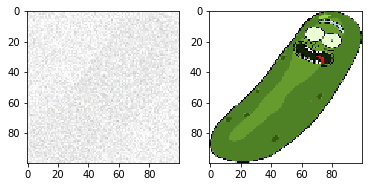

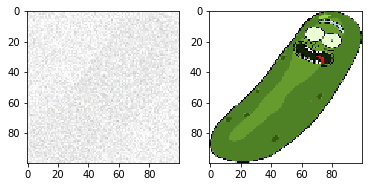

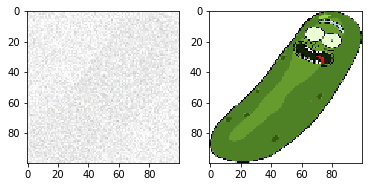

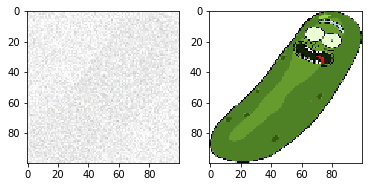

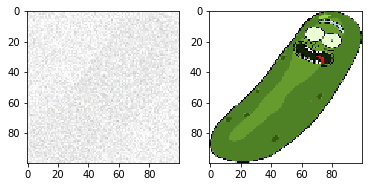

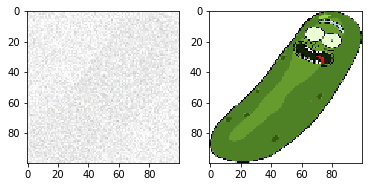

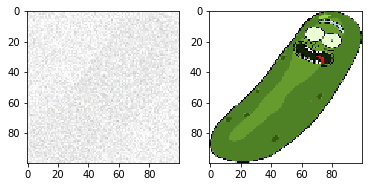

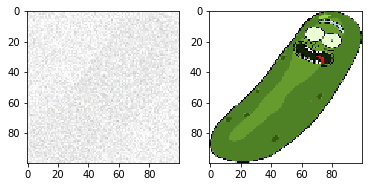

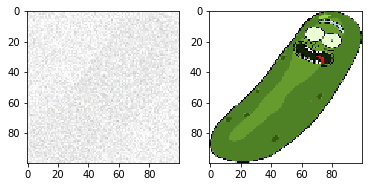

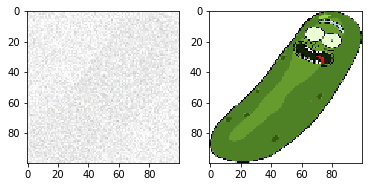

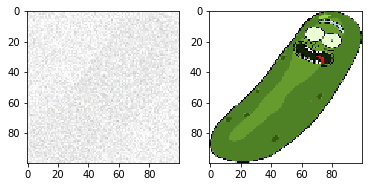

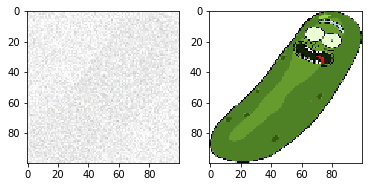

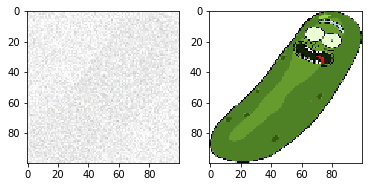

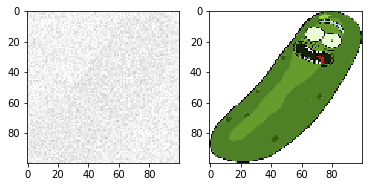

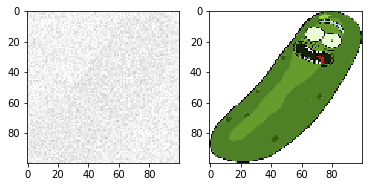

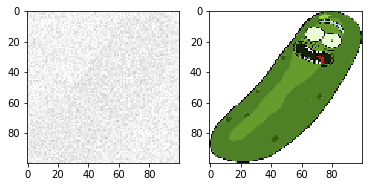

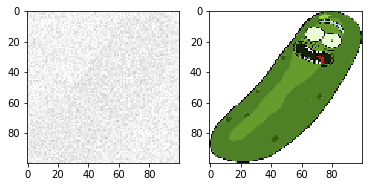

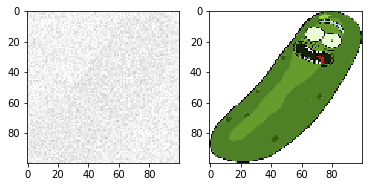

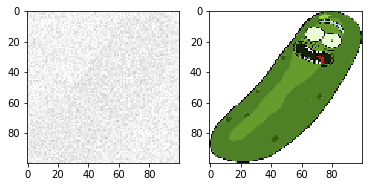

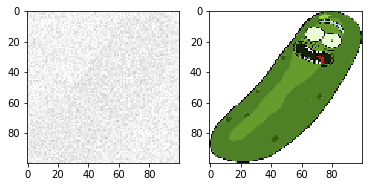

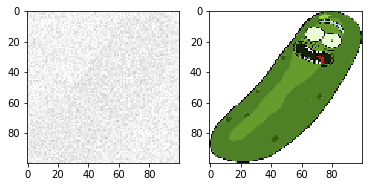

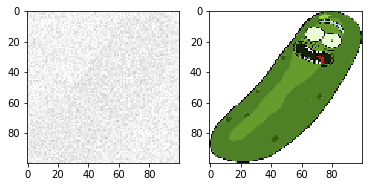

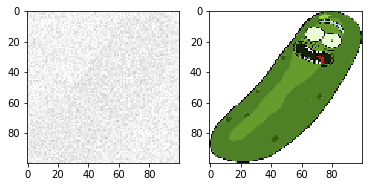

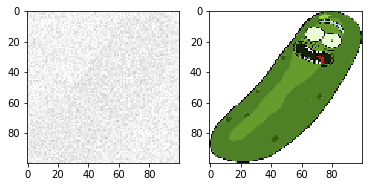

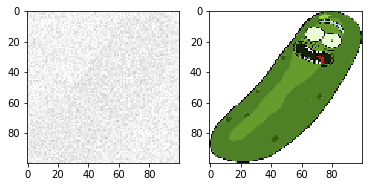

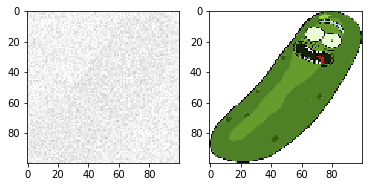

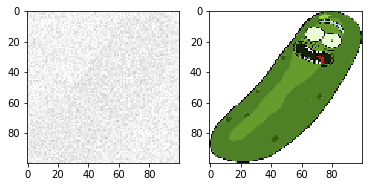

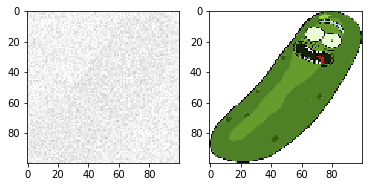

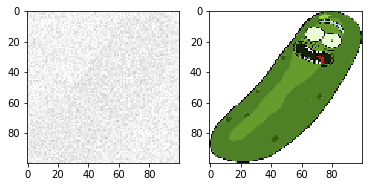

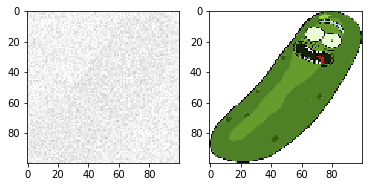

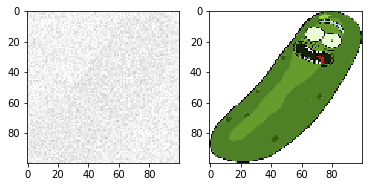

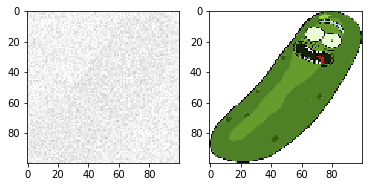

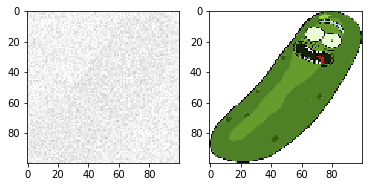

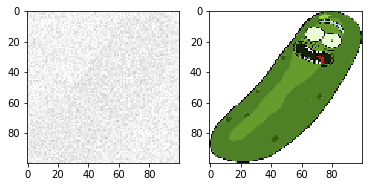

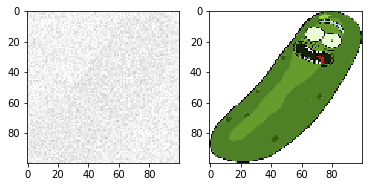

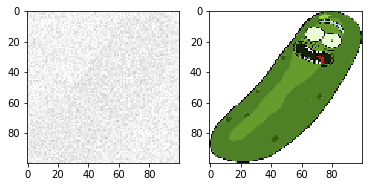

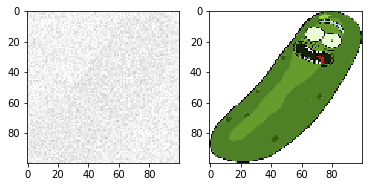

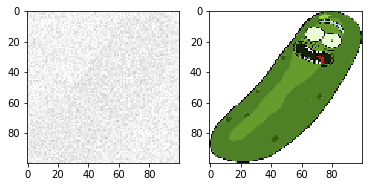

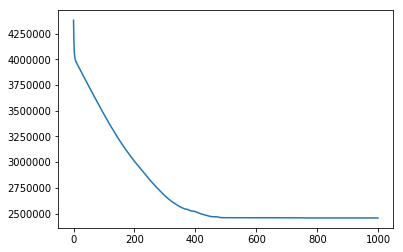

In [78]:
find_closest(x, optimize_simple, mutate_simple, pop_size=1000, n_iters=1000)